# Modeling<a id='Modeling'></a>

## 1 Contents<a id='1_Contents'></a>
* [Preprocessing](#Preprocessing)
  * [1 Contents](#1_Contents)
  * [2 Introduction](#2_Introduction)
  * [3 Imports](#3_Imports)
  * [4 Load the data](#4_Load_the_data)
  * [5 Baseline](#5_Baseline)
  * [6 Simple Regression](#6_Simple_Regression)
  * [7 Random Forest](#7_Random_Forest)
  * [8 More Sophisticated Regression](#8_More_Sophisticated_Regression)
  * [9 Save the model](#9_Save_the_model)
  * [10 Summary](#10_Summary)

## 2 Introduction<a id='2_Introduction'></a>

We train various models on our prepared data, starting with simplistic baseline models, then a simple linear regression model, and then some more complex models. In each case, we are actually training three models: one for shots on goal, one for assists, and one for goals. However, we see that the performance for each type of model follows a similar pattern throughout, regardless of which stat we are considering.

## 3 Imports<a id='3_Imports'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

from sklearn import __version__ as sklearn_version
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline

from library.sb_utils import save_file

## 4 Load the data<a id='4_Load_the_data'></a>

In [2]:
datapath = '../data/processed/'

X_lastwindows = pd.read_csv(datapath + 'X_lastwindows.csv')
X_test = pd.read_csv(datapath + 'X_test.csv')
X_train = pd.read_csv(datapath + 'X_train.csv')
Y_lastwindows = pd.read_csv(datapath + 'Y_lastwindows.csv')
Y_test = pd.read_csv(datapath + 'Y_test.csv')
Y_train = pd.read_csv(datapath + 'Y_train.csv')

## 5 Baselines<a id='5_Baselines'></a>

We consider three overly-simplistic models to establish a baseline: the first is a dummy model which takes the median of each value in Y_train and uses that as the prediction, the second is a model which selects just the most recent window feature as the prediction, and the third takes the average of each player's performance over all five recent windows.

In [3]:
# We manually define dummy predictions instead of using sklearn DummyRegressor because we want dataframes instead of numpy arrays.

Y_tr_dummy = pd.DataFrame(index=Y_train.index)
Y_te_dummy = pd.DataFrame(index=Y_test.index)
Y_lw_dummy = pd.DataFrame(index=Y_lastwindows.index)

medians = Y_train.median()

for df in [Y_tr_dummy, Y_te_dummy, Y_lw_dummy]:
    for col in ['goals_per_games', 'assists_per_games', 'shots_on_goal_per_games']:
        df[col] = medians[col]

In [4]:
# Again, we manually define our simplistic baseline prediction functions.

def predict_most_recent(X):         # simply predicts that each player will repeat their performance from the previous window
    Y = pd.DataFrame(index=X.index)
    Y['assists_per_games'] = X['assists_1_per_games_1']
    Y['goals_per_games'] = X['goals_1_per_games_1']
    Y['shots_on_goal_per_games'] = X['shots_on_goal_1_per_games_1']
    return Y

def recent_avg(X,stat):
    avg = (X[stat + '_1_per_games_1'] + X[stat + '_2_per_games_2'] + X[stat + '_3_per_games_3'] + X[stat + '_4_per_games_4'] + X[stat + '_5_per_games_5']) / 5
    return avg

def predict_average(X):             # predicts each player's average over all five windows
    Y = pd.DataFrame(index=X.index)
    Y['assists_per_games'] = recent_avg(X,'assists')
    Y['goals_per_games'] = recent_avg(X,'goals')
    Y['shots_on_goal_per_games'] = recent_avg(X,'shots_on_goal')
    return Y

In [5]:
def baseline_performance(f, stat, X, Y):
    Y_f = f(X)      # f could be the identity, if instead of feature data X we pass predicted data. (We do this for the dummy prediction.)
    r2 = r2_score(Y[stat], Y_f[stat])
    mae = mean_absolute_error(Y[stat], Y_f[stat])
    mse = mean_squared_error(Y[stat], Y_f[stat])
    print(f'r2_score: {r2:.3f}, mae: {mae:.3f}, mse: {mse:.3f}')

In [6]:
def show_base(stat):
    print(stat + ' using dummy (median):')
    print('train:')
    baseline_performance(lambda x:x, stat, Y_tr_dummy, Y_train) # instead of passing f = dummy and X, we pass identity function and dummy(X)
    print('test:')
    baseline_performance(lambda x:x, stat, Y_te_dummy, Y_test)
    print('lw:')
    baseline_performance(lambda x:x, stat, Y_lw_dummy, Y_lastwindows)
    print('\n')
    print(stat + ' using most recent:')
    print('train:')
    baseline_performance(predict_most_recent, stat, X_train, Y_train)
    print('test:')
    baseline_performance(predict_most_recent, stat, X_test, Y_test)
    print('lw:')
    baseline_performance(predict_most_recent, stat, X_lastwindows, Y_lastwindows)
    print('\n')
    print(stat + ' using average:')
    print('train:')
    baseline_performance(predict_average, stat, X_train, Y_train)
    print('test:')
    baseline_performance(predict_average, stat, X_test, Y_test)
    print('lw:')
    baseline_performance(predict_average, stat, X_lastwindows, Y_lastwindows)

In [7]:
Y_train.median()

assists_per_games          0.217391
goals_per_games            0.115385
shots_on_goal_per_games    1.523810
dtype: float64

### Goals

In [8]:
show_base('goals_per_games')

goals_per_games using dummy (median):
train:
r2_score: -0.060, mae: 0.100, mse: 0.019
test:
r2_score: -0.067, mae: 0.101, mse: 0.019
lw:
r2_score: -0.110, mae: 0.103, mse: 0.020


goals_per_games using most recent:
train:
r2_score: 0.125, mae: 0.092, mse: 0.015
test:
r2_score: 0.017, mae: 0.096, mse: 0.018
lw:
r2_score: 0.184, mae: 0.088, mse: 0.015


goals_per_games using average:
train:
r2_score: 0.374, mae: 0.081, mse: 0.011
test:
r2_score: 0.363, mae: 0.083, mse: 0.011
lw:
r2_score: 0.311, mae: 0.078, mse: 0.013


We see that for goals scored per game, taking an average of the five recent windows yields a slightly better prediction than just the recent window, and both are better than the dummy predictor, but the mean absolute error is still relatively high compared to the median value, meaning there should be some room for improvement in a more elaborate model. Let's see what it looks like for assists and shots as well.

### Assists

In [9]:
show_base('assists_per_games')

assists_per_games using dummy (median):
train:
r2_score: -0.034, mae: 0.138, mse: 0.033
test:
r2_score: -0.045, mae: 0.139, mse: 0.035
lw:
r2_score: -0.082, mae: 0.138, mse: 0.036


assists_per_games using most recent:
train:
r2_score: 0.193, mae: 0.122, mse: 0.026
test:
r2_score: 0.165, mae: 0.127, mse: 0.028
lw:
r2_score: 0.333, mae: 0.114, mse: 0.022


assists_per_games using average:
train:
r2_score: 0.419, mae: 0.106, mse: 0.019
test:
r2_score: 0.403, mae: 0.108, mse: 0.020
lw:
r2_score: 0.498, mae: 0.101, mse: 0.017


### Shots on Goal

In [10]:
show_base('shots_on_goal_per_games')

shots_on_goal_per_games using dummy (median):
train:
r2_score: -0.024, mae: 0.603, mse: 0.595
test:
r2_score: -0.034, mae: 0.602, mse: 0.597
lw:
r2_score: -0.068, mae: 0.591, mse: 0.602


shots_on_goal_per_games using most recent:
train:
r2_score: 0.599, mae: 0.372, mse: 0.233
test:
r2_score: 0.578, mae: 0.381, mse: 0.244
lw:
r2_score: 0.607, mae: 0.365, mse: 0.222


shots_on_goal_per_games using average:
train:
r2_score: 0.680, mae: 0.334, mse: 0.186
test:
r2_score: 0.676, mae: 0.339, mse: 0.187
lw:
r2_score: 0.673, mae: 0.333, mse: 0.184


Although the errors are higher for these stats, relative to their median values these are actually lower, especially for shots. This is not surprising, given that shots happen with much more regularity. Otherwise, we a similar pattern to the results as for goals.

## 6 Simple Regression<a id='6_Simple_Regression'></a>

Our baselines were effectively three linear models with hand-selected coefficients: a constant model, a model with a 1 coefficient for one feature and 0s otherwise, and a model with 0.2 coefficient for five features and 0s otherwise. Let's see what linear model we get via simple regression with no normalization.

In [11]:
def show_metrics(y, y_pred):
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    print(f'r2_score: {r2:.3f}, mae: {mae:.3f}, mse: {mse:.3f}')

In [12]:
simple_pipe = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

In [13]:
def reg_model(pipe, stat):
    pipe.fit(X_train, Y_train[stat])
    y_tr_pred = pipe.predict(X_train)
    y_te_pred = pipe.predict(X_test)
    y_lw_pred = pipe.predict(X_lastwindows)
    print('train:')
    show_metrics(Y_train[stat], y_tr_pred)
    print('test')
    show_metrics(Y_test[stat], y_te_pred)
    print('lw:')
    show_metrics(Y_lastwindows[stat], y_lw_pred)
    # we print the most significant coefficients as well
    coefs = pipe.named_steps.linearregression.coef_
    if 'polynomialfeatures' in pipe.named_steps.keys(): # this part is for later when we try adding polynomial features
        features = pipe.named_steps.polynomialfeatures.get_feature_names_out()
    else:
        features = X_train.columns
    coef_series = pd.Series(coefs, index=features).sort_values(ascending=True)
    max_coef = coef_series.max()
    min_coef = coef_series.min()
    cutoff = max(max_coef, abs(min_coef)) / 8
    print('\n')
    print('Significant coefficients:')
    print(coef_series[(coef_series > cutoff) | (coef_series < -cutoff)])
    

### Shots on Goal

In [14]:
reg_model(simple_pipe, 'shots_on_goal_per_games')

train:
r2_score: 0.732, mae: 0.307, mse: 0.156
test
r2_score: 0.724, mae: 0.310, mse: 0.159
lw:
r2_score: 0.724, mae: 0.301, mse: 0.155


Significant coefficients:
age                             -0.161764
pp_toi_4_per_games_4            -0.041795
goals_2_per_games_2              0.021448
assists_1_per_games_1            0.024893
pp_toi_2_per_games_2             0.027484
attempted_shots_4_per_games_4    0.033121
shots_on_goal_3_per_games_3      0.034532
shots_on_goal_4_per_games_4      0.044841
goals_1_per_games_1              0.046909
pp_toi_1_per_games_1             0.047047
attempted_shots_3_per_games_3    0.050176
shots_on_goal_2_per_games_2      0.060992
shots_on_goal_5_per_games_5      0.063075
attempted_shots_2_per_games_2    0.064968
toi_1_per_games_1                0.071610
isForward                        0.076130
shots_on_goal_1_per_games_1      0.102530
age_squared                      0.105887
attempted_shots_1_per_games_1    0.148040
dtype: float64


The best baseline had r2: ~0.676, mae: ~0.336, mse: ~0.186, so this model has meaningfully improved over the baseline.

### Assists

In [15]:
reg_model(simple_pipe, 'assists_per_games')

train:
r2_score: 0.522, mae: 0.095, mse: 0.015
test
r2_score: 0.502, mae: 0.099, mse: 0.017
lw:
r2_score: 0.595, mae: 0.090, mse: 0.013


Significant coefficients:
age                             -0.029575
shots_on_goal_2_per_games_2     -0.009296
toi_3_per_games_3               -0.009079
pp_toi_4_per_games_4            -0.008366
weight                          -0.005757
shots_on_goal_4_per_games_4     -0.004951
toi_5_per_games_5               -0.004139
attempted_shots_5_per_games_5    0.004217
pp_toi_5_per_games_5             0.004672
recent_team_goals_per_game       0.005095
pp_toi_2_per_games_2             0.005157
onice_attempts_5_per_games_5     0.005849
onice_attempts_2_per_games_2     0.006459
pp_toi_3_per_games_3             0.008809
assists_3_per_games_3            0.008947
assists_4_per_games_4            0.009013
onice_attempts_4_per_games_4     0.009184
assists_5_per_games_5            0.009503
onice_attempts_1_per_games_1     0.009521
attempted_shots_2_per_games_2    0.012

### Goals

In [16]:
reg_model(simple_pipe, 'goals_per_games')

train:
r2_score: 0.514, mae: 0.069, mse: 0.009
test
r2_score: 0.510, mae: 0.071, mse: 0.009
lw:
r2_score: 0.550, mae: 0.068, mse: 0.008


Significant coefficients:
age                             -0.025378
toi_3_per_games_3               -0.008540
shots_on_goal_3_per_games_3      0.005203
onice_attempts_5_per_games_5     0.005385
goals_3_per_games_3              0.005557
shots_on_goal_1_per_games_1      0.005811
onice_attempts_4_per_games_4     0.006002
assists_1_per_games_1            0.006023
shots_on_goal_5_per_games_5      0.006322
onice_attempts_3_per_games_3     0.009769
pp_toi_1_per_games_1             0.010353
attempted_shots_1_per_games_1    0.010530
goals_2_per_games_2              0.011205
toi_1_per_games_1                0.011973
goals_1_per_games_1              0.014286
age_squared                      0.016677
isForward                        0.040856
dtype: float64


Comparing to our baselines above, we have also seen a meaningful improvement for assists and for goals. Interestingly, we are not seeing any evidence of overfitting, leaving room to explore more complex models.

## 7 Random Forest<a id='7_Random_Forest'></a>

Let's see if we can train a model to beat our simple linear regression model. We first try a random forest model.

In [17]:
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=37)
)

In [18]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=9)]
grid_params = {
        'randomforestregressor__n_estimators': n_est
}
grid_params

{'randomforestregressor__n_estimators': [10,
  17,
  31,
  56,
  100,
  177,
  316,
  562,
  1000]}

In [19]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [20]:
rf_grid_cv.fit(X_train, Y_train['goals_per_games'])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=37))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 17, 31, 56,
                                                                 100, 177, 316,
                                                                 562, 1000]})

Fitting these models took over 16 minutes, compared to the milliseconds that our linear regression model took. Was it worth it?

In [21]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 1000}

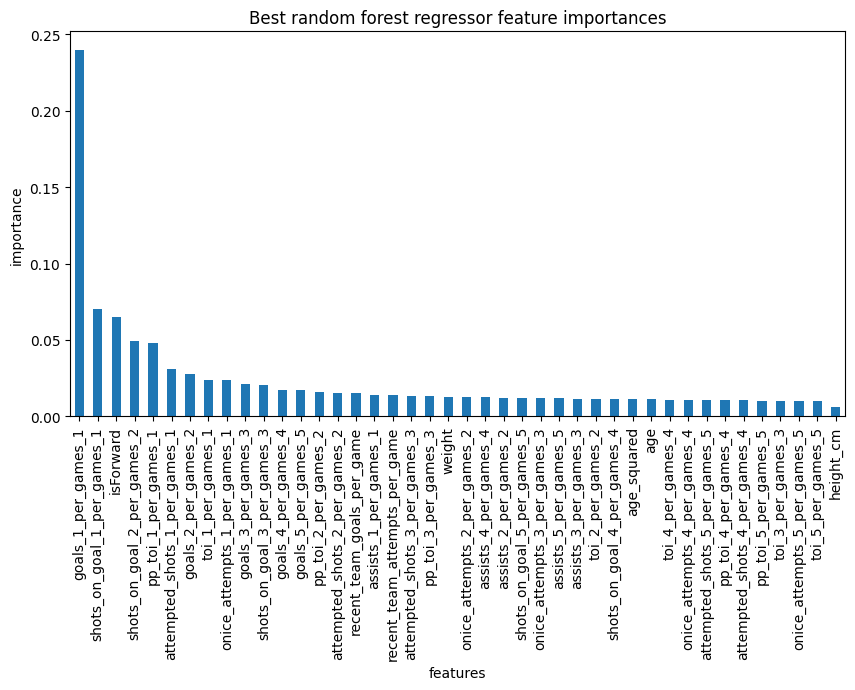

In [22]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [23]:
y_tr_rf_goals = rf_grid_cv.predict(X_train)
y_te_rf_goals = rf_grid_cv.predict(X_test)
y_lw_rf_goals = rf_grid_cv.predict(X_lastwindows)

print('train:')
show_metrics(Y_train['goals_per_games'], y_tr_rf_goals)
print('test:')
show_metrics(Y_test['goals_per_games'], y_te_rf_goals)
print('lw:')
show_metrics(Y_lastwindows['goals_per_games'], y_lw_rf_goals)

train:
r2_score: 0.934, mae: 0.026, mse: 0.001
test:
r2_score: 0.514, mae: 0.071, mse: 0.009
lw:
r2_score: 0.583, mae: 0.066, mse: 0.008


The resulting model has significantly overfit to the training data, and achieves similar results on the test data as the linear model. Although we have far from exhausted the parameters to explore with random forests, it does not seem like a promising approach, given that the enormously longer training time does not seem to have gained us anything.

## 8 More Sophisticated Regression<a id='8_More_Sophisticated_Regression'></a>

Let's now turn back to our linear model.

In [24]:
fractions = [.025, .05, .1, .15, .25, .35, .45, .55, .7, .85, 1.0]
train_size, train_scores, test_scores = learning_curve(simple_pipe, X_train, Y_train['goals_per_games'], train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

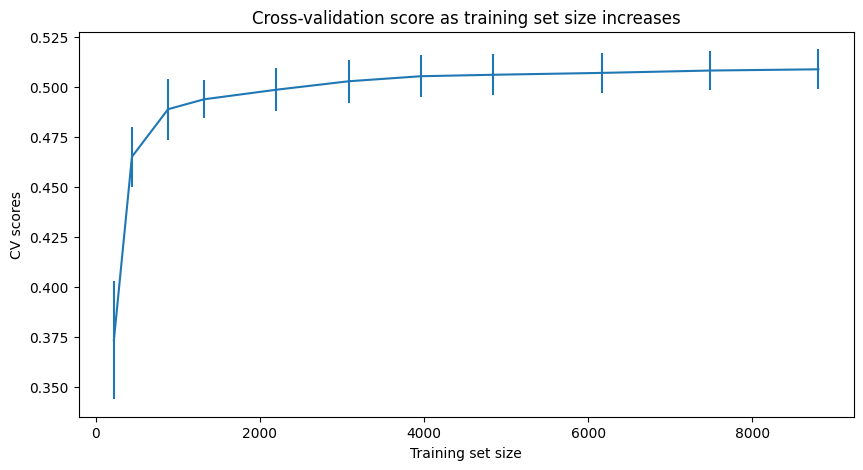

In [25]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

We see that we have plenty of data, so the best hope to improve our results is to increase the complexity of our model. Let's try adding in some polynomial features

In [26]:
poly_pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=2, interaction_only=True),
    LinearRegression()
)

### Shots on Goal

In [27]:
reg_model(poly_pipe, 'shots_on_goal_per_games')

train:
r2_score: 0.763, mae: 0.290, mse: 0.137
test
r2_score: 0.708, mae: 0.319, mse: 0.169
lw:
r2_score: 0.689, mae: 0.311, mse: 0.175


Significant coefficients:
x3       -0.610347
x4 x31   -0.402749
x3 x27   -0.324516
x0 x3    -0.230286
x4 x38   -0.228959
            ...   
x0 x4     0.221015
x3 x38    0.225051
x4 x27    0.317288
x3 x31    0.419210
x4        0.579613
Length: 86, dtype: float64


### Assists

In [28]:
reg_model(poly_pipe, 'assists_per_games')

train:
r2_score: 0.585, mae: 0.089, mse: 0.013
test
r2_score: 0.482, mae: 0.100, mse: 0.017
lw:
r2_score: 0.564, mae: 0.093, mse: 0.014


Significant coefficients:
x4 x13   -0.111008
x3 x11   -0.102513
x4 x22   -0.096365
x4       -0.090584
x3 x20   -0.084450
            ...   
x3        0.072658
x3 x22    0.095301
x4 x11    0.099920
x4 x20    0.100959
x3 x13    0.111286
Length: 189, dtype: float64


### Goals

In [29]:
reg_model(poly_pipe, 'goals_per_games')

train:
r2_score: 0.573, mae: 0.065, mse: 0.008
test
r2_score: 0.484, mae: 0.073, mse: 0.009
lw:
r2_score: 0.549, mae: 0.069, mse: 0.008


Significant coefficients:
x3 x18   -0.077126
x4 x38   -0.073228
x3 x24   -0.065102
x3 x34   -0.063531
x4 x31   -0.061835
            ...   
x4 x24    0.062911
x3 x31    0.063501
x4 x34    0.065518
x4 x18    0.071305
x3 x38    0.073526
Length: 194, dtype: float64


These models are now starting to overfit, with slightly better performance on the training set than the linear model had, but slightly worse on the test sets.

## 9 Save the model<a id='9_Save_the_model'></a>

The clear winner out of the models we explored is the simple linear regression model, which performs as well as or better than all the rest, while also being one of the most simple and lightweight. Let's save the specific model for each stat separately.

In [30]:
%%capture
reg_model(simple_pipe, 'shots_on_goal_per_games')

In [31]:
sog_model = simple_pipe
sog_model.version = 1.0
sog_model.pandas_version = pd.__version__
sog_model.numpy_version = np.__version__
sog_model.sklearn_version = sklearn_version
sog_model.X_columns = [col for col in X_train.columns]
sog_model.build_datetime = dt.datetime.now()

In [32]:
modelpath = '../models'
save_file(sog_model, 'shots_on_goal_model.pkl', modelpath)

Writing file.  "../models\shots_on_goal_model.pkl"


In [33]:
%%capture
reg_model(simple_pipe, 'assists_per_games')

In [34]:
ass_model = simple_pipe
ass_model.version = 1.0
ass_model.pandas_version = pd.__version__
ass_model.numpy_version = np.__version__
ass_model.sklearn_version = sklearn_version
ass_model.X_columns = [col for col in X_train.columns]
ass_model.build_datetime = dt.datetime.now()

In [35]:
modelpath = '../models'
save_file(ass_model, 'assists_model.pkl', modelpath)

Writing file.  "../models\assists_model.pkl"


In [36]:
%%capture
reg_model(simple_pipe, 'goals_per_games')

In [37]:
goal_model = simple_pipe
goal_model.version = 1.0
goal_model.pandas_version = pd.__version__
goal_model.numpy_version = np.__version__
goal_model.sklearn_version = sklearn_version
goal_model.X_columns = [col for col in X_train.columns]
goal_model.build_datetime = dt.datetime.now()

In [38]:
modelpath = '../models'
save_file(goal_model, 'goals_model.pkl', modelpath)

Writing file.  "../models\goals_model.pkl"


## 10 Summary<a id='11_Summary'></a>

Our simple linear regression model for each statistic performed meaningfully better than our baselines, while matching other more complex models. None of our attempts to increase complexity yielded any promise for improvement via further tweaking, so we have settled on the simple linear regression model.

We also saw that our model is comfortably along the learning curve, with more rows unlikely to yield significantly better results. However, it is interesting to note that the features age, age_squared, and isForward are among the largest coefficients, suggesting that acquiring mode data for each player or engineering new features could be the most impactful way to improve the model.